Доверительный интервал для среднего ущерба: [9,017,432.10, 9,280,826.81]
Средняя абсолютная ошибка модели: $85,779.17
R² модели: 1.00


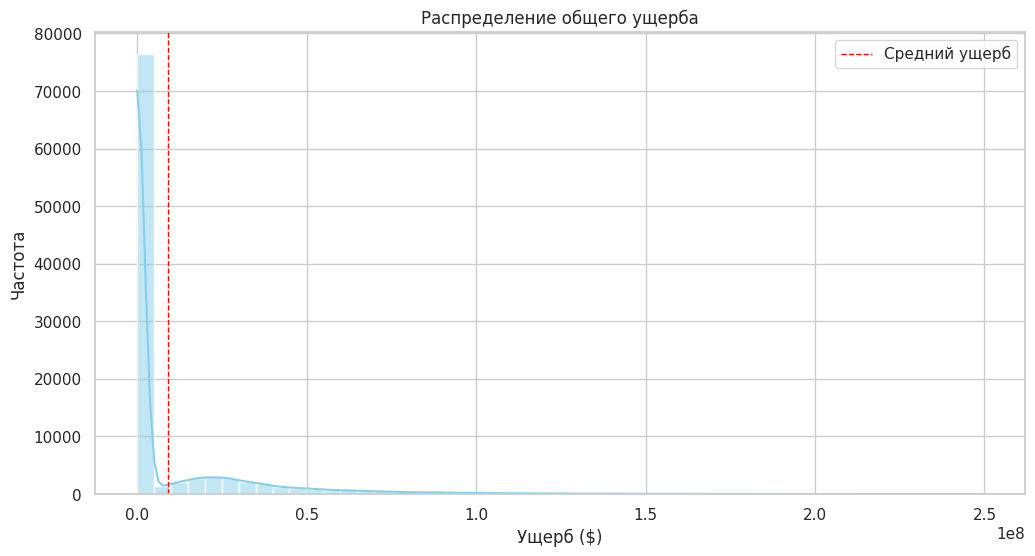

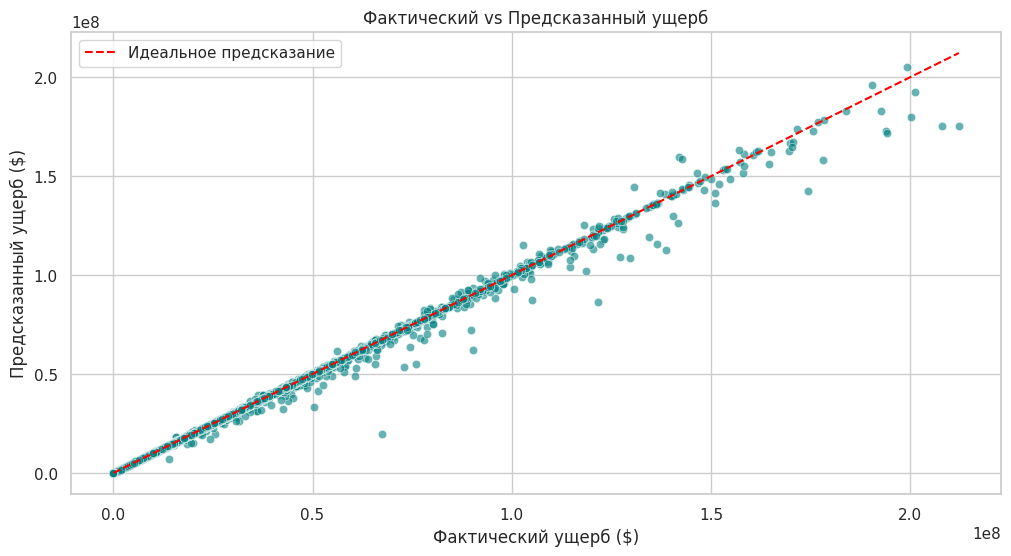

Средний ущерб с учетом мер: $9,147,120.26


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Определяем сценарии катастроф
scenarios = {
    "earthquake": {"probability": 0.01, "mean_damage": 1e8, "std_dev": 5e7, "mitigation_cost": 0.15},
    "flood": {"probability": 0.05, "mean_damage": 5e7, "std_dev": 2e7, "mitigation_cost": 0.10},
    "tech_failure": {"probability": 0.1, "mean_damage": 2e7, "std_dev": 1e7, "mitigation_cost": 0.05},
    "hurricane": {"probability": 0.03, "mean_damage": 8e7, "std_dev": 4e7, "mitigation_cost": 0.20},
    "fire": {"probability": 0.08, "mean_damage": 3e7, "std_dev": 1.5e7, "mitigation_cost": 0.12},
}

# Параметры симуляции
n_simulations = 100000
total_damages = []
damage_details = []

for _ in range(n_simulations):
    total_damage = 0
    scenario_details = {}
    hurricane_happened = False

    for scenario, params in scenarios.items():
        probability = params["probability"]

        # Зависимость сценариев: ураган → наводнение
        if scenario == "flood" and hurricane_happened:
            probability *= 2  # Увеличение вероятности

        if np.random.rand() < probability:  # Событие происходит
            damage = np.random.normal(params["mean_damage"], params["std_dev"])
            damage = max(damage, 0)  # Ущерб не может быть отрицательным
            mitigation = params["mitigation_cost"] * damage
            total_damage += (damage - mitigation)
            scenario_details[scenario] = damage - mitigation
            if scenario == "hurricane":
                hurricane_happened = True
        else:
            scenario_details[scenario] = 0

    total_damages.append(total_damage)
    damage_details.append(scenario_details)

# Преобразуем данные в DataFrame
df = pd.DataFrame(damage_details)
df["total_damage"] = total_damages

# Доверительные интервалы
bootstrap_samples = 1000
bootstrap_means = []

for _ in range(bootstrap_samples):
    sample = np.random.choice(total_damages, size=len(total_damages), replace=True)
    bootstrap_means.append(np.mean(sample))

ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)

print(f"Доверительный интервал для среднего ущерба: [{ci_lower:,.2f}, {ci_upper:,.2f}]")

# Модель машинного обучения
X = df.drop(columns=["total_damage"])
y = df["total_damage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Оценка модели
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Средняя абсолютная ошибка модели: ${mae:,.2f}")
print(f"R² модели: {r2:.2f}")

# Визуализация
sns.set(style="whitegrid")

# Гистограмма ущерба
plt.figure(figsize=(12, 6))
sns.histplot(total_damages, bins=50, kde=True, color='skyblue')
plt.axvline(np.mean(total_damages), color='red', linestyle='dashed', linewidth=1, label="Средний ущерб")
plt.title("Распределение общего ущерба")
plt.xlabel("Ущерб ($)")
plt.ylabel("Частота")
plt.legend()
plt.show()

# Фактический vs предсказанный ущерб
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred, color='teal', alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], linestyle='--', color='red', label="Идеальное предсказание")
plt.title("Фактический vs Предсказанный ущерб")
plt.xlabel("Фактический ущерб ($)")
plt.ylabel("Предсказанный ущерб ($)")
plt.legend()
plt.show()

# Средний ущерб после учета мер
mean_mitigated_damage = np.mean(total_damages)
print(f"Средний ущерб с учетом мер: ${mean_mitigated_damage:,.2f}")
